In [1]:
%%HTML
<style>
h4 {
    --background: #F7A5A5;
    --foreground: red;
    background-color: var(--background);
    border: 2px solid var(--foreground);
    padding: 20px;
    border-radius: 10px;
    color: var(--foreground);
}
h1 {
    --background: #20BEFFBB;
    --foreground: blue;
    background-color: var(--background);
    border: 2px solid var(--foreground);
    padding: 20px;
    border-radius: 10px;
    color: var(--foreground);
}
h3 {
    --background: #FFCE84;
    --foreground: #F07108;
    background-color: var(--background);
    border: 2px solid var(--foreground);
    padding: 10px;
    border-radius: 10px;
    color: var(--foreground);
    width: 50%;
}
</style>

# Directory Structure

In [2]:
!mkdir saved_exp_info
!mkdir saved_exp_info/acc
!mkdir saved_exp_info/final_model
!mkdir saved_exp_info/len_dbs
!mkdir saved_exp_info/local_model_history
!mkdir saved_exp_info/loss
!mkdir saved_exp_info/sampled_clients
!mkdir saved_exp_info/server_history

# Clustering

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
from copy import deepcopy
from itertools import product
from numpy.random import choice
from scipy.cluster.hierarchy import fcluster

"""
FILE OUTLINE:
1. get_clusters_with_alg1               : Algorithm 1: Client Sample Weights => Sampling Probabilities (*)

-  get_similarity                       : Measures Similarity Between 2 Gradient Arrays

-  get_gradients                        : Computes Gradients from Global Model and Local Model

4. get_matrix_similarity_from_grads     : 

5. get_matrix_similarity                : 

6. get_clusters_with_alg2               : Algorithm 2: Client Sample Weights => Sampling Probabilities (*)

7. sample_clients                       : Sample Clients from a given CLient Sampling Probability Distribution.
"""


def get_clusters_with_alg1(n_sampled: int, weights: np.array):
    """ALGORITHM 1"""
    epsilon = int(10**10)
    # associate each client to a cluster
    augmented_weights = np.array([w * n_sampled * epsilon for w in weights])
    ordered_client_idx = np.flip(np.argsort(augmented_weights))
    n_clients = len(weights)
    distri_clusters = np.zeros((n_sampled, n_clients)).astype(int)
    k = 0
    for client_idx in ordered_client_idx:
        while augmented_weights[client_idx] > 0:
            sum_proba_in_k = np.sum(distri_clusters[k])
            u_i = min(epsilon - sum_proba_in_k, augmented_weights[client_idx])
            distri_clusters[k, client_idx] = u_i
            augmented_weights[client_idx] += -u_i
            sum_proba_in_k = np.sum(distri_clusters[k])
            if sum_proba_in_k == 1 * epsilon:
                k += 1
    distri_clusters = distri_clusters.astype(float)
    for l in range(n_sampled):
        distri_clusters[l] /= np.sum(distri_clusters[l])
    return distri_clusters


def get_similarity(grad_1, grad_2, distance_type="L1"):
    if distance_type == "L1":
        norm = 0
        for g_1, g_2 in zip(grad_1, grad_2):
            norm += np.sum(np.abs(g_1 - g_2))
        return norm
    elif distance_type == "L2":
        norm = 0
        for g_1, g_2 in zip(grad_1, grad_2):
            norm += np.sum((g_1 - g_2) ** 2)
        return norm
    elif distance_type == "cosine":
        norm, norm_1, norm_2 = 0, 0, 0
        for i in range(len(grad_1)):
            norm += np.sum(grad_1[i] * grad_2[i])
            norm_1 += np.sum(grad_1[i] ** 2)
            norm_2 += np.sum(grad_2[i] ** 2)
        if norm_1 == 0.0 or norm_2 == 0.0:
            return 0.0
        else:
            norm /= np.sqrt(norm_1 * norm_2)
            return np.arccos(norm)


def get_gradients(sampling, global_m, local_models):
    """return the `representative gradient` formed by the difference between
    the local work and the sent global model"""
    local_model_params = []
    for model in local_models:
        local_model_params += [
            [tens.detach().numpy() for tens in list(model.parameters())]
        ]
    global_model_params = [
        tens.detach().numpy() for tens in list(global_m.parameters())
    ]
    local_model_grads = []
    for local_params in local_model_params:
        local_model_grads += [
            [
                local_weights - global_weights
                for local_weights, global_weights in zip(
                    local_params, global_model_params
                )
            ]
        ]
    return local_model_grads


def get_matrix_similarity_from_grads(local_model_grads, distance_type):
    """return the similarity matrix where the distance chosen to
    compare two clients is set with `distance_type`"""
    n_clients = len(local_model_grads)
    metric_matrix = np.zeros((n_clients, n_clients))
    for i, j in product(range(n_clients), range(n_clients)):
        metric_matrix[i, j] = get_similarity(
            local_model_grads[i], local_model_grads[j], distance_type
        )
    return metric_matrix


def get_matrix_similarity(global_m, local_models, distance_type):
    n_clients = len(local_models)
    local_model_grads = get_gradients(global_m, local_models)
    metric_matrix = np.zeros((n_clients, n_clients))
    for i, j in product(range(n_clients), range(n_clients)):
        metric_matrix[i, j] = get_similarity(
            local_model_grads[i], local_model_grads[j], distance_type
        )
    return metric_matrix


def get_clusters_with_alg2(linkage_matrix: np.array, n_sampled: int, weights: np.array):
    """ALGORITHM 2"""
    epsilon = int(10**10)
    # associate each client to a cluster
    link_matrix_p = deepcopy(linkage_matrix)
    augmented_weights = deepcopy(weights)
    for i in range(len(link_matrix_p)):
        idx_1, idx_2 = int(link_matrix_p[i, 0]), int(link_matrix_p[i, 1])
        new_weight = np.array([augmented_weights[idx_1] + augmented_weights[idx_2]])
        augmented_weights = np.concatenate((augmented_weights, new_weight))
        link_matrix_p[i, 2] = int(new_weight * epsilon)
    clusters = fcluster(link_matrix_p, int(epsilon / n_sampled), criterion="distance")
    n_clients, n_clusters = len(clusters), len(set(clusters))
    # Associate each cluster to its number of clients in the cluster
    pop_clusters = np.zeros((n_clusters, 2)).astype(int)
    for i in range(n_clusters):
        pop_clusters[i, 0] = i + 1
        for client in np.where(clusters == i + 1)[0]:
            pop_clusters[i, 1] += int(weights[client] * epsilon * n_sampled)
    pop_clusters = pop_clusters[pop_clusters[:, 1].argsort()]
    distri_clusters = np.zeros((n_sampled, n_clients)).astype(int)
    # n_sampled biggest clusters that will remain unchanged
    kept_clusters = pop_clusters[n_clusters - n_sampled :, 0]
    for idx, cluster in enumerate(kept_clusters):
        for client in np.where(clusters == cluster)[0]:
            distri_clusters[idx, client] = int(weights[client] * n_sampled * epsilon)
    k = 0
    for j in pop_clusters[: n_clusters - n_sampled, 0]:
        clients_in_j = np.where(clusters == j)[0]
        np.random.shuffle(clients_in_j)
        for client in clients_in_j:
            weight_client = int(weights[client] * epsilon * n_sampled)
            while weight_client > 0:
                sum_proba_in_k = np.sum(distri_clusters[k])
                u_i = min(epsilon - sum_proba_in_k, weight_client)
                distri_clusters[k, client] = u_i
                weight_client += -u_i
                sum_proba_in_k = np.sum(distri_clusters[k])
                if sum_proba_in_k == 1 * epsilon:
                    k += 1
    distri_clusters = distri_clusters.astype(float)
    for l in range(n_sampled):
        distri_clusters[l] /= np.sum(distri_clusters[l])
    return distri_clusters


def sample_clients(distri_clusters):
    n_clients = len(distri_clusters[0])
    n_sampled = len(distri_clusters)
    sampled_clients = np.zeros(len(distri_clusters), dtype=int)
    for k in range(n_sampled):
        sampled_clients[k] = int(choice(n_clients, 1, p=distri_clusters[k]))
    return sampled_clients


# Fed Prox

In [4]:
#!/usr/bin/env python
# coding: utf-8

import torch
import pickle
import random
import numpy as np
import torch.nn as nn
from copy import deepcopy
import torch.optim as optim


def set_to_zero_model_weights(model):
    """SETTING ALL THE PARAMETERS OF THE MODEL TO 0"""
    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)


def FedAvg_agregation_process(model, clients_models_hist: list, weights: list):
    """Creates the new model of a given iteration with the models of the other clients"""
    new_model = deepcopy(model)
    set_to_zero_model_weights(new_model)
    for k, client_hist in enumerate(clients_models_hist):
        for idx, layer_weights in enumerate(new_model.parameters()):
            contribution = client_hist[idx].data * weights[k]
            layer_weights.data.add_(contribution)
    return new_model


def FedAvg_agregation_process_for_FA_sampling(
    model, clients_models_hist: list, weights: list
):
    """Creates the new model of a given iteration with the models of the other
    clients"""
    new_model = deepcopy(model)
    for layer_weigths in new_model.parameters():
        layer_weigths.data.sub_(sum(weights) * layer_weigths.data)
    for k, client_hist in enumerate(clients_models_hist):
        for idx, layer_weights in enumerate(new_model.parameters()):
            contribution = client_hist[idx].data * weights[k]
            layer_weights.data.add_(contribution)
    return new_model


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `test_data`"""
    correct = 0
    for features, labels in dataset:
        predictions = model(features)
        _, predicted = predictions.max(1, keepdim=True)
        correct += torch.sum(predicted.view(-1, 1) == labels.view(-1, 1)).item()
    accuracy = 100 * correct / len(dataset.dataset)
    return accuracy


def loss_dataset(model, train_data, loss_f):
    """Compute the loss of `model` on `test_data`"""
    loss = 0
    for idx, (features, labels) in enumerate(train_data):
        predictions = model(features)
        loss += loss_f(predictions, labels)
    loss /= idx + 1
    return loss


def loss_classifier(predictions, labels):
    criterion = nn.CrossEntropyLoss()
    return criterion(predictions, labels)


def n_params(model):
    """return the number of parameters in the model"""
    n_params = sum(
        [
            np.prod([tensor.size()[k] for k in range(len(tensor.size()))])
            for tensor in list(model.parameters())
        ]
    )
    return n_params


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters"""
    tensor_1 = list(model_1.parameters())
    tensor_2 = list(model_2.parameters())
    norm = sum(
        [torch.sum((tensor_1[i] - tensor_2[i]) ** 2) for i in range(len(tensor_1))]
    )
    return norm


def local_learning(model, mu: float, optimizer, train_data, n_SGD: int, loss_f):
    model_0 = deepcopy(model)
    for _ in range(n_SGD):
        features, labels = next(iter(train_data))
        optimizer.zero_grad()
        predictions = model(features)
        batch_loss = loss_f(predictions, labels)
        batch_loss += mu / 2 * difference_models_norm_2(model, model_0)
        batch_loss.backward()
        optimizer.step()


def save_pkl(dictionnary, directory, file_name):
    """Save the dictionnary in the directory under the file_name with pickle"""
    with open(f"saved_exp_info/{directory}/{file_name}.pkl", "wb") as output:
        pickle.dump(dictionnary, output)


def FedProx_sampling_random(
    model,
    n_sampled,
    training_sets: list,
    testing_sets: list,
    n_iter: int,
    n_SGD: int,
    lr,
    file_name: str,
    decay=1,
    metric_period=1,
    mu=0,
):
    """all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            trainign set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularixation term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """
    loss_f = loss_classifier
    K = len(training_sets)  # number of clients
    n_samples = np.array([len(db.dataset) for db in training_sets])
    weights = n_samples / np.sum(n_samples)
    print("Clients' weights:", weights)
    loss_hist = np.zeros((n_iter + 1, K))
    acc_hist = np.zeros((n_iter + 1, K))
    for k, dl in enumerate(training_sets):
        loss_hist[0, k] = float(loss_dataset(model, dl, loss_f).detach())
        acc_hist[0, k] = accuracy_dataset(model, dl)
    # LOSS AND ACCURACY OF THE INITIAL MODEL
    server_loss = np.dot(weights, loss_hist[0])
    server_acc = np.dot(weights, acc_hist[0])
    print(f"====> i: 0 Loss: {server_loss} Test Accuracy: {server_acc}")
    sampled_clients_hist = np.zeros((n_iter, K)).astype(int)
    for i in range(n_iter):
        clients_params = []
        np.random.seed(i)
        sampled_clients = np.random.choice(K, size=n_sampled, replace=True, p=weights)
        for k in sampled_clients:
            local_model = deepcopy(model)
            local_optimizer = optim.SGD(local_model.parameters(), lr=lr)
            local_learning(
                local_model,
                mu,
                local_optimizer,
                training_sets[k],
                n_SGD,
                loss_f,
            )
            # GET THE PARAMETER TENSORS OF THE MODEL
            list_params = list(local_model.parameters())
            list_params = [tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            sampled_clients_hist[i, k] = 1
        # CREATE THE NEW GLOBAL MODEL
        model = FedAvg_agregation_process(
            deepcopy(model), clients_params, weights=[1 / n_sampled] * n_sampled
        )
        if i % metric_period == 0:
            # COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
            for k, dl in enumerate(training_sets):
                loss_hist[i + 1, k] = float(loss_dataset(model, dl, loss_f).detach())

            for k, dl in enumerate(testing_sets):
                acc_hist[i + 1, k] = accuracy_dataset(model, dl)

            server_loss = np.dot(weights, loss_hist[i + 1])
            server_acc = np.dot(weights, acc_hist[i + 1])

            print(
                f"====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}"
            )

        # DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr *= decay
    # SAVE THE DIFFERENT TRAINING HISTORY
    #    save_pkl(models_hist, "local_model_history", file_name)
    #    save_pkl(server_hist, "server_history", file_name)
    save_pkl(loss_hist, "loss", file_name)
    save_pkl(acc_hist, "acc", file_name)
    save_pkl(sampled_clients_hist, "sampled_clients", file_name)
    torch.save(model.state_dict(), f"saved_exp_info/final_model/{file_name}.pth")
    return model, loss_hist, acc_hist


def FedProx_clustered_sampling(
    sampling: str,
    model,
    n_sampled: int,
    training_sets: list,
    testing_sets: list,
    n_iter: int,
    n_SGD: int,
    lr: float,
    file_name: str,
    sim_type: str,
    iter_FP=0,
    decay=1.0,
    metric_period=1,
    mu=0.0,
):
    """all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            trainign set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularixation term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """
    from scipy.cluster.hierarchy import linkage
#     from py_func.clustering import get_matrix_similarity_from_grads
#     if sampling == "clustered_2":
#         from py_func.clustering import get_clusters_with_alg2
#     from py_func.clustering import sample_clients
    loss_f = loss_classifier
    # Variables initialization
    K = len(training_sets)  # number of clients
    n_samples = np.array([len(db.dataset) for db in training_sets])
    weights = n_samples / np.sum(n_samples)
    print("Clients' weights:", weights)
    loss_hist = np.zeros((n_iter + 1, K))
    acc_hist = np.zeros((n_iter + 1, K))
    for k, dl in enumerate(training_sets):
        loss_hist[0, k] = float(loss_dataset(model, dl, loss_f).detach())
        acc_hist[0, k] = accuracy_dataset(model, dl)
    # LOSS AND ACCURACY OF THE INITIAL MODEL
    server_loss = np.dot(weights, loss_hist[0])
    server_acc = np.dot(weights, acc_hist[0])
    print(f"====> i: 0 Loss: {server_loss} Test Accuracy: {server_acc}")
    sampled_clients_hist = np.zeros((n_iter, K)).astype(int)
    # INITILIZATION OF THE GRADIENT HISTORY AS A LIST OF 0
    if sampling == "clustered_1":
#         from py_func.clustering import get_clusters_with_alg1
        distri_clusters = get_clusters_with_alg1(n_sampled, weights)
    elif sampling == "clustered_2":
#         from py_func.clustering import get_gradients
        gradients = get_gradients(sampling, model, [model] * K)
    for i in range(n_iter):
        previous_global_model = deepcopy(model)
        clients_params = []
        clients_models = []
        sampled_clients_for_grad = []
        if i < iter_FP:
            print("MD sampling")
            np.random.seed(i)
            sampled_clients = np.random.choice(
                K, size=n_sampled, replace=True, p=weights
            )
            for k in sampled_clients:
                local_model = deepcopy(model)
                local_optimizer = optim.SGD(local_model.parameters(), lr=lr)
                local_learning(
                    local_model,
                    mu,
                    local_optimizer,
                    training_sets[k],
                    n_SGD,
                    loss_f,
                )
                # SAVE THE LOCAL MODEL TRAINED
                list_params = list(local_model.parameters())
                list_params = [tens_param.detach() for tens_param in list_params]
                clients_params.append(list_params)
                clients_models.append(deepcopy(local_model))

                sampled_clients_for_grad.append(k)
                sampled_clients_hist[i, k] = 1
        else:
            if sampling == "clustered_2":
                # GET THE CLIENTS' SIMILARITY MATRIX
                sim_matrix = get_matrix_similarity_from_grads(
                    gradients, distance_type=sim_type
                )
                # GET THE DENDROGRAM TREE ASSOCIATED
                linkage_matrix = linkage(sim_matrix, "ward")
                distri_clusters = get_clusters_with_alg2(
                    linkage_matrix, n_sampled, weights
                )
            for k in sample_clients(distri_clusters):
                local_model = deepcopy(model)
                local_optimizer = optim.SGD(local_model.parameters(), lr=lr)
                local_learning(
                    local_model,
                    mu,
                    local_optimizer,
                    training_sets[k],
                    n_SGD,
                    loss_f,
                )
                # SAVE THE LOCAL MODEL TRAINED
                list_params = list(local_model.parameters())
                list_params = [tens_param.detach() for tens_param in list_params]
                clients_params.append(list_params)
                clients_models.append(deepcopy(local_model))
                sampled_clients_for_grad.append(k)
                sampled_clients_hist[i, k] = 1
        # CREATE THE NEW GLOBAL MODEL AND SAVE IT
        model = FedAvg_agregation_process(
            deepcopy(model), clients_params, weights=[1 / n_sampled] * n_sampled
        )
        # COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        if i % metric_period == 0:
            for k, dl in enumerate(training_sets):
                loss_hist[i + 1, k] = float(loss_dataset(model, dl, loss_f).detach())
            for k, dl in enumerate(testing_sets):
                acc_hist[i + 1, k] = accuracy_dataset(model, dl)
            server_loss = np.dot(weights, loss_hist[i + 1])
            server_acc = np.dot(weights, acc_hist[i + 1])
            print(
                f"====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}"
            )
        # UPDATE THE HISTORY OF LATEST GRADIENT
        if sampling == "clustered_2":
            gradients_i = get_gradients(sampling, previous_global_model, clients_models)
            for idx, gradient in zip(sampled_clients_for_grad, gradients_i):
                gradients[idx] = gradient

        lr *= decay
    # SAVE THE DIFFERENT TRAINING HISTORY
    #    save_pkl(models_hist, "local_model_history", file_name)
    #    save_pkl(server_hist, "server_history", file_name)
    save_pkl(loss_hist, "loss", file_name)
    save_pkl(acc_hist, "acc", file_name)
    save_pkl(sampled_clients_hist, "sampled_clients", file_name)
    torch.save(model.state_dict(), f"saved_exp_info/final_model/{file_name}.pth")
    return model, loss_hist, acc_hist


def FedProx_sampling_target(
    model,
    n_sampled: int,
    training_sets: list,
    testing_sets: list,
    n_iter: int,
    n_SGD: int,
    lr,
    file_name: str,
    decay=1,
    mu=0,
):
    """all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            trainign set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularixation term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """
    loss_f = loss_classifier
    # Variables initialization
    n_samples = sum([len(db.dataset) for db in training_sets])
    weights = [len(db.dataset) / n_samples for db in training_sets]
    print("Clients' weights:", weights)
    loss_hist = [
        [float(loss_dataset(model, dl, loss_f).detach()) for dl in training_sets]
    ]
    acc_hist = [[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist = [
        [tens_param.detach().numpy() for tens_param in list(model.parameters())]
    ]
    models_hist = []
    sampled_clients_hist = []
    server_loss = sum([weights[i] * loss_hist[-1][i] for i in range(len(weights))])
    server_acc = sum([weights[i] * acc_hist[-1][i] for i in range(len(weights))])
    print(f"====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}")
    for i in range(n_iter):
        clients_params = []
        clients_models = []
        sampled_clients_i = []
        for j in range(n_sampled):
            k = j * 10 + np.random.randint(10)
            local_model = deepcopy(model)
            local_optimizer = optim.SGD(local_model.parameters(), lr=lr)
            local_learning(
                local_model,
                mu,
                local_optimizer,
                training_sets[k],
                n_SGD,
                loss_f,
            )
            # GET THE PARAMETER TENSORS OF THE MODEL
            list_params = list(local_model.parameters())
            list_params = [tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))
            sampled_clients_i.append(k)
        # CREATE THE NEW GLOBAL MODEL
        model = FedAvg_agregation_process(
            deepcopy(model), clients_params, weights=[1 / n_sampled] * n_sampled
        )
        models_hist.append(clients_models)
        # COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist += [
            [float(loss_dataset(model, dl, loss_f).detach()) for dl in training_sets]
        ]
        acc_hist += [[accuracy_dataset(model, dl) for dl in testing_sets]]
        server_loss = sum([weights[i] * loss_hist[-1][i] for i in range(len(weights))])
        server_acc = sum([weights[i] * acc_hist[-1][i] for i in range(len(weights))])
        print(f"====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}")
        server_hist.append(deepcopy(model))
        sampled_clients_hist.append(sampled_clients_i)
        # DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr *= decay
    # SAVE THE DIFFERENT TRAINING HISTORY
    #    save_pkl(models_hist, "local_model_history", file_name)
    #    save_pkl(server_hist, "server_history", file_name)
    save_pkl(loss_hist, "loss", file_name)
    save_pkl(acc_hist, "acc", file_name)
    save_pkl(sampled_clients_hist, "sampled_clients", file_name)
    torch.save(model.state_dict(), f"saved_exp_info/final_model/{file_name}.pth")
    return model, loss_hist, acc_hist


def FedProx_FedAvg_sampling(
    model,
    n_sampled,
    training_sets: list,
    testing_sets: list,
    n_iter: int,
    n_SGD: int,
    lr,
    file_name: str,
    decay=1,
    metric_period=1,
    mu=0,
):
    """all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            trainign set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularixation term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """
    loss_f = loss_classifier
    K = len(training_sets)  # number of clients
    n_samples = np.array([len(db.dataset) for db in training_sets])
    weights = n_samples / np.sum(n_samples)
    print("Clients' weights:", weights)
    loss_hist = np.zeros((n_iter + 1, K))
    acc_hist = np.zeros((n_iter + 1, K))
    for k, dl in enumerate(training_sets):
        loss_hist[0, k] = float(loss_dataset(model, dl, loss_f).detach())
        acc_hist[0, k] = accuracy_dataset(model, dl)
    # LOSS AND ACCURACY OF THE INITIAL MODEL
    server_loss = np.dot(weights, loss_hist[0])
    server_acc = np.dot(weights, acc_hist[0])
    print(f"====> i: 0 Loss: {server_loss} Test Accuracy: {server_acc}")
    sampled_clients_hist = np.zeros((n_iter, K)).astype(int)
    for i in range(n_iter):
        clients_params = []
        np.random.seed(i)
        sampled_clients = random.sample([x for x in range(K)], n_sampled)
        print("sampled clients", sampled_clients)
        for k in sampled_clients:
            local_model = deepcopy(model)
            local_optimizer = optim.SGD(local_model.parameters(), lr=lr)
            local_learning(
                local_model,
                mu,
                local_optimizer,
                training_sets[k],
                n_SGD,
                loss_f,
            )
            # GET THE PARAMETER TENSORS OF THE MODEL
            list_params = list(local_model.parameters())
            list_params = [tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)

            sampled_clients_hist[i, k] = 1
        # CREATE THE NEW GLOBAL MODEL
        model = FedAvg_agregation_process_for_FA_sampling(
            deepcopy(model),
            clients_params,
            weights=[weights[client] for client in sampled_clients],
        )
        if i % metric_period == 0:
            # COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
            for k, dl in enumerate(training_sets):
                loss_hist[i + 1, k] = float(loss_dataset(model, dl, loss_f).detach())

            for k, dl in enumerate(testing_sets):
                acc_hist[i + 1, k] = accuracy_dataset(model, dl)

            server_loss = np.dot(weights, loss_hist[i + 1])
            server_acc = np.dot(weights, acc_hist[i + 1])

            print(
                f"====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}"
            )

        # DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr *= decay

    # SAVE THE DIFFERENT TRAINING HISTORY
    #    save_pkl(models_hist, "local_model_history", file_name)
    #    save_pkl(server_hist, "server_history", file_name)
    save_pkl(loss_hist, "loss", file_name)
    save_pkl(acc_hist, "acc", file_name)
    save_pkl(sampled_clients_hist, "sampled_clients", file_name)
    torch.save(model.state_dict(), f"saved_exp_info/final_model/{file_name}.pth")
    return model, loss_hist, acc_hist


# Create Model

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F


class NN(nn.Module):
    def __init__(self, layer_1, layer_2):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(784, layer_1)
        self.fc3 = nn.Linear(layer_1, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        x = self.fc3(x)
        return x


# class CNN_CIFAR(torch.nn.Module):
#   """Model Used by the paper introducing FedAvg"""
#   def __init__(self):
#        super(CNN_CIFAR, self).__init__()
#        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32, kernel_size=(3,3))
#        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3))
#        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3))
#
#        self.fc1 = nn.Linear(4*4*64, 64)
#        self.fc2 = nn.Linear(64, 10)
#
#   def forward(self, x):
#        x = F.relu(self.conv1(x))
#        x = F.max_pool2d(x, 2, 2)
#
#        x = F.relu(self.conv2(x))
#        x = F.max_pool2d(x, 2, 2)
#
#        x=self.conv3(x)
#        x = x.view(-1, 4*4*64)
#
#        x = F.relu(self.fc1(x))
#
#        x = self.fc2(x)
#        return x


class CNN_CIFAR_dropout(torch.nn.Module):
    """Model Used by the paper introducing FedAvg"""

    def __init__(self):
        super(CNN_CIFAR_dropout, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=(3, 3)
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 3)
        )
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=(3, 3)
        )

        self.fc1 = nn.Linear(4 * 4 * 64, 64)
        self.fc2 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.dropout(x)
        x = x.view(-1, 4 * 4 * 64)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        return x


def load_model(dataset, seed):
    torch.manual_seed(seed)
    if dataset == "MNIST_shard" or dataset == "MNIST_iid":
        model = NN(50, 10)
    elif dataset[:7] == "CIFAR10":
        #        model = CNN_CIFAR()
        model = CNN_CIFAR_dropout()
    return model

# Read Data

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import torch
import pickle
import numpy as np
from copy import deepcopy
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#
# -------------------------- MNIST NON-IID --------------------------
#


def get_1shard(ds, row_0: int, digit: int, samples: int):
    """__UTILITY FUNCTION__: return an array from `ds` of `digit` starting of `row_0` in the indices of `ds`"""
    # STEP 1
    row = row_0  # STARTING ROW INDEX
    shard = list()  # ACTUAL SAMPLES FROM MAIN DATASET
    # STEP 2
    while len(shard) < samples:  # COLLECT SAMPLES OF SAME DIGIT FROM 'ds'
        if ds.train_labels[row] == digit:
            shard.append(ds.train_data[row].numpy())
        row += 1
    # STEP 3
    return row, shard  # RETURN THE (END INDEX, THE DATA CHUNK OF SIZE 'samples')


def create_MNIST_ds_1shard_per_client(n_clients, samples_train, samples_test):
    # STEP 1: LOAD TRAIN AND TEST DATASET OF 'MNIST'
    MNIST_train = datasets.MNIST(root="./data", train=True, download=True)
    MNIST_test = datasets.MNIST(root="./data", train=False, download=True)
    # STEP 2
    shards_train, shards_test = [], []  # CLIENTS FROM 1 TO 100
    labels = []  # LABELS OF EACH CLIENT (TOTAL CLIENTS = 100)
    # STEP 3
    for i in range(10):  # FOR EACH DIGIT CREATE 10 CLIENTS
        row_train, row_test = 0, 0
        for j in range(10):
            row_train, shard_train = get_1shard(
                MNIST_train, row_train, i, samples_train
            )  # COLLECT A TRAIN SHARD FOR EACH CLIENT
            row_test, shard_test = get_1shard(
                MNIST_test, row_test, i, samples_test
            )  # COLLECT A TEST SHARD FOR EACH CLIENT
            # STORE THE COLLECTED SHARDS
            shards_train.append([shard_train])
            shards_test.append([shard_test])
            # STORE THE LABEL
            labels += [[i]]
    # STEP 4: DATA VARIABLES
    X_train = np.array(shards_train)
    X_test = np.array(shards_test)
    y_train = deepcopy(labels)
    y_test = deepcopy(labels)
    # STEP 5: SAVE THE VARIABLES TO FLIE
    out_folder = "./data/"
    train_path = f"MNIST_shard_train_{n_clients}_{samples_train}.pkl"
    with open(out_folder + train_path, "wb") as output:
        pickle.dump((X_train, y_train), output)
    test_path = f"MNIST_shard_test_{n_clients}_{samples_test}.pkl"
    with open(out_folder + test_path, "wb") as output:
        pickle.dump((X_test, y_test), output)


def create_MNIST_small_niid(
    n_clients: int,
    samples_train: list,
    samples_test: list,
    clients_digits: list,
):
    MNIST_train = datasets.MNIST(root="./data", train=True, download=True)
    MNIST_test = datasets.MNIST(root="./data", train=False, download=True)
    X_train, X_test = [], []
    y_train, y_test = [], []
    for digits, n_train, n_test in zip(clients_digits, samples_train, samples_test):
        client_samples_train, client_samples_test = [], []
        client_labels_train, client_labels_test = [], []
        n_train_per_shard = int(n_train / len(digits))
        n_test_per_shard = int(n_test / len(digits))
        for digit in digits:
            row_train, row_test = 0, 0
            _, shard_train = get_1shard(
                MNIST_train, row_train, digit, n_train_per_shard
            )
            _, shard_test = get_1shard(MNIST_test, row_test, digit, n_test_per_shard)
            client_samples_train += shard_train
            client_samples_test += shard_test
            client_labels_train += [digit] * n_train_per_shard
            client_labels_test += [digit] * n_test_per_shard
        X_train.append(client_samples_train)
        X_test.append(client_samples_test)
        y_train.append(client_labels_train)
        y_test.append(client_labels_test)
    folder = "./data/"
    train_path = f"MNIST_small_shard_train_{n_clients}_{samples_train}.pkl"
    with open(folder + train_path, "wb") as output:
        pickle.dump((np.array(X_train), np.array(y_train)), output)
    test_path = f"MNIST_small_shard_test_{n_clients}_{samples_test}.pkl"
    with open(folder + test_path, "wb") as output:
        pickle.dump((np.array(X_test), np.array(y_test)), output)


class MnistShardDataset(Dataset):
    """Convert the MNIST pkl file into a Pytorch Dataset"""
    def __init__(self, file_path, k):
        with open(file_path, "rb") as pickle_file:
            dataset = pickle.load(pickle_file)
            self.features = np.vstack(dataset[0][k])
            vector_labels = list()
            for idx, digit in enumerate(dataset[1][k]):
                vector_labels += [digit] * len(dataset[0][k][idx])
            self.labels = np.array(vector_labels)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        # 3D input 1x28x28
        x = torch.Tensor([self.features[idx]]) / 255
        y = torch.LongTensor([self.labels[idx]])[0]

        return x, y


def clients_set_MNIST_shard(file_name, n_clients, batch_size=100, shuffle=True):
    """Download for all the clients their respective dataset"""
    print(file_name)
    list_dl = list()
    for k in range(n_clients):
        dataset_object = MnistShardDataset(file_name, k)
        dataset_dl = DataLoader(dataset_object, batch_size=batch_size, shuffle=shuffle)
        list_dl.append(dataset_dl)
    return list_dl


#
# ----------------------------------------- CIFAR 10 Dirichilet distribution -------------------------------------------
#


def partition_CIFAR_dataset(
    dataset,
    file_name: str,
    balanced: bool,
    matrix,
    n_clients: int,
    n_classes: int,
    train: bool,
):
    """Partition dataset into `n_clients`.
    Each client i has matrix[k, i] of data of class k"""
    list_clients_X = [[] for i in range(n_clients)]
    list_clients_y = [[] for i in range(n_clients)]
    if balanced:
        n_samples = [500] * n_clients
    elif not balanced and train:
        n_samples = [100] * 10 + [250] * 30 + [500] * 30 + [750] * 20 + [1000] * 10
    elif not balanced and not train:
        n_samples = [20] * 10 + [50] * 30 + [100] * 30 + [150] * 20 + [200] * 10
    list_idx = []
    for k in range(n_classes):
        idx_k = np.where(np.array(dataset.targets) == k)[0]
        list_idx += [idx_k]
    for idx_client, n_sample in enumerate(n_samples):
        clients_idx_i = []
        client_samples = 0
        for k in range(n_classes):
            if k < 9:
                samples_digit = int(matrix[idx_client, k] * n_sample)
            if k == 9:
                samples_digit = n_sample - client_samples
            client_samples += samples_digit
            clients_idx_i = np.concatenate(
                (clients_idx_i, np.random.choice(list_idx[k], samples_digit))
            )
        clients_idx_i = clients_idx_i.astype(int)
        for idx_sample in clients_idx_i:
            list_clients_X[idx_client] += [dataset.data[idx_sample]]
            list_clients_y[idx_client] += [dataset.targets[idx_sample]]
        list_clients_X[idx_client] = np.array(list_clients_X[idx_client])
    folder = "./data/"
    with open(folder + file_name, "wb") as output:
        pickle.dump((list_clients_X, list_clients_y), output)

def create_CIFAR10_dirichlet(
    dataset_name: str,
    balanced: bool,
    alpha: float,
    n_clients: int,
    n_classes: int,
):
    """Create a CIFAR dataset partitioned according to a
    dirichilet distribution Dir(alpha)"""
    from numpy.random import dirichlet
    matrix = dirichlet([alpha] * n_classes, size=n_clients)
    CIFAR10_train = datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    CIFAR10_test = datasets.CIFAR10(
        root="./data",
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
    file_name_train = f"{dataset_name}_train_{n_clients}.pkl"
    partition_CIFAR_dataset(
        CIFAR10_train,
        file_name_train,
        balanced,
        matrix,
        n_clients,
        n_classes,
        True,
    )
    file_name_test = f"{dataset_name}_test_{n_clients}.pkl"
    partition_CIFAR_dataset(
        CIFAR10_test,
        file_name_test,
        balanced,
        matrix,
        n_clients,
        n_classes,
        False,
    )


class CIFARDataset(Dataset):
    """Convert the CIFAR pkl file into a Pytorch Dataset"""
    def __init__(self, file_path: str, k: int):
        dataset = pickle.load(open(file_path, "rb"))
        self.X = dataset[0][k]
        self.y = np.array(dataset[1][k])
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx: int):
        # 3D input 32x32x3
        x = torch.Tensor(self.X[idx]).permute(2, 0, 1) / 255
        x = (x - 0.5) / 0.5
        y = self.y[idx]
        return x, y


def clients_set_CIFAR(file_name: str, n_clients: int, batch_size: int, shuffle=True):
    """Download for all the clients their respective dataset"""
    print(file_name)
    list_dl = list()
    for k in range(n_clients):
        dataset_object = CIFARDataset(file_name, k)
        dataset_dl = DataLoader(dataset_object, batch_size=batch_size, shuffle=shuffle)
        list_dl.append(dataset_dl)
    return list_dl


#
# --------------------------------------- Upload any dataset Puts all the function above together ------------------------------------------
#


def get_dataloaders(dataset, batch_size: int, shuffle=True):
    folder = "./data/"
    if dataset == "MNIST_iid":
        n_clients = 100
        samples_train, samples_test = 600, 100
        mnist_trainset = datasets.MNIST(
            root="./data",
            train=True,
            download=True,
            transform=transforms.ToTensor(),
        )
        mnist_train_split = torch.utils.data.random_split(
            mnist_trainset, [samples_train] * n_clients
        )
        list_dls_train = [
            torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            for ds in mnist_train_split
        ]
        mnist_testset = datasets.MNIST(
            root="./data",
            train=False,
            download=True,
            transform=transforms.ToTensor(),
        )
        mnist_test_split = torch.utils.data.random_split(
            mnist_testset, [samples_test] * n_clients
        )
        list_dls_test = [
            torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            for ds in mnist_test_split
        ]
    elif dataset == "MNIST_shard":
        n_clients = 100
        samples_train, samples_test = 500, 80
        file_name_train = f"MNIST_shard_train_{n_clients}_{samples_train}.pkl"
        path_train = folder + file_name_train
        file_name_test = f"MNIST_shard_test_{n_clients}_{samples_test}.pkl"
        path_test = folder + file_name_test
        if not os.path.isfile(path_train):
            create_MNIST_ds_1shard_per_client(n_clients, samples_train, samples_test)
        list_dls_train = clients_set_MNIST_shard(
            path_train, n_clients, batch_size=batch_size, shuffle=shuffle
        )
        list_dls_test = clients_set_MNIST_shard(
            path_test, n_clients, batch_size=batch_size, shuffle=shuffle
        )
    elif dataset == "CIFAR10_iid":
        n_clients = 100
        samples_train, samples_test = 500, 100
        CIFAR10_train = datasets.CIFAR10(
            root="./data",
            train=True,
            download=True,
            transform=transforms.ToTensor(),
        )
        CIFAR10_train_split = torch.utils.data.random_split(
            CIFAR10_train, [samples_train] * n_clients
        )
        list_dls_train = [
            torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            for ds in CIFAR10_train_split
        ]
        CIFAR10_test = datasets.CIFAR10(
            root="./data",
            train=False,
            download=True,
            transform=transforms.ToTensor(),
        )
        CIFAR10_test_split = torch.utils.data.random_split(
            CIFAR10_test, [samples_test] * n_clients
        )
        list_dls_test = [
            torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True)
            for ds in CIFAR10_test_split
        ]
    elif dataset[:5] == "CIFAR":
        n_classes = 10
        n_clients = 100
        balanced = dataset[8:12] == "bbal"
        alpha = float(dataset[13:])
        file_name_train = f"{dataset}_train_{n_clients}.pkl"
        path_train = folder + file_name_train
        file_name_test = f"{dataset}_test_{n_clients}.pkl"
        path_test = folder + file_name_test
        if not os.path.isfile(path_train):
            print("creating dataset alpha:", alpha)
            create_CIFAR10_dirichlet(dataset, balanced, alpha, n_clients, n_classes)
        list_dls_train = clients_set_CIFAR(path_train, n_clients, batch_size, True)
        list_dls_test = clients_set_CIFAR(path_test, n_clients, batch_size, True)
    
    # Save in a file the number of samples owned per client
    list_len = list()
    for dl in list_dls_train:
        list_len.append(len(dl.dataset))
    with open(f"./saved_exp_info/len_dbs/{dataset}.pkl", "wb") as output:
        pickle.dump(list_len, output)
    return list_dls_train, list_dls_test

# Hyperparameters

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


def get_hyperparams(dataset, n_SGD):
    """return the different hyperparameters considered for the experiments.
    This function enables the user to put less input to FL_CS2.py"""
    batch_size = 50
    if dataset == "MNIST_iid":
        n_iter = 600
    elif dataset == "MNIST_shard":
        n_iter = 600
    elif dataset[:5] == "CIFAR":
        n_iter = 1000
    if dataset[:5] == "CIFAR":
        if n_SGD <= 10:
            n_iter = int(n_iter * 2)
        elif n_SGD >= 200:
            n_iter = int(n_iter / 2)
        if n_SGD >= 200:
            metric_period = 3
        elif n_SGD == 100:
            metric_period = 5
        elif n_SGD == 50:
            metric_period = 5
        elif n_SGD <= 10:
            metric_period = 10
    else:
        if n_SGD <= 10:
            n_iter = int(n_iter * 2)
        elif n_SGD >= 100:
            n_iter = int(n_iter / 2)
        metric_period = 2
    n_iter = 100
    return n_iter, batch_size, metric_period


def get_file_name(
    dataset: str,
    sampling: str,
    sim_type: str,
    seed: int,
    n_SGD: int,
    lr: float,
    decay: float,
    p: float,
    mu: float,
):
    """return the file name under which the experiment with these info is saved
    under"""
    n_iter, batch_size, meas_perf_period = get_hyperparams(dataset, n_SGD)
    file_name = (
        f"{dataset}_{sampling}_{sim_type}_i{n_iter}_N{n_SGD}_lr{lr}"
        + f"_B{batch_size}_d{decay}_p{p}_m{meas_perf_period}_{seed}"
    )
    if mu != 0.0:
        file_name += f"_{mu}"
    return file_name


def get_CIFAR10_alphas():
    """Return the different alpha considered for the dirichlet distribution"""
    return [0.001, 0.01, 0.1, 10.0]


# Expermentation (Clustered 1)

In [8]:
import os
import sys

print("dataset - sampling - sim_type - seed - n_SGD - lr - decay - p - force - mu")
# HYPER PARAMETERS
dataset = "MNIST_shard"
sampling = "clustered_1"
sim_type = "cosine"
seed = int(0)
n_SGD = int(50)
lr = float(0.01)
decay = float(0.95)
p = float(0.1)
force = False

try:
    mu = float(sys.argv[10])
except:
    mu = 0.0
"""GET THE HYPERPARAMETERS"""
n_iter, batch_size, meas_perf_period = get_hyperparams(dataset, n_SGD)
n_iter = 150
print("number of iterations", n_iter)
print("batch size", batch_size)
print("percentage of sampled clients", p)
print("metric_period", meas_perf_period)
print("regularization term", mu)


"""NAME UNDER WHICH THE EXPERIMENT'S VARIABLES WILL BE SAVED"""
file_name = get_file_name(dataset, sampling, sim_type, seed, n_SGD, lr, decay, p, mu)
print(file_name)


"""GET THE DATASETS USED FOR THE FL TRAINING"""
list_dls_train, list_dls_test = get_dataloaders(dataset, batch_size)


"""NUMBER OF SAMPLED CLIENTS"""
n_sampled = int(p * len(list_dls_train))
print("number fo sampled clients", n_sampled)


"""LOAD THE INTIAL GLOBAL MODEL"""
model_0 = load_model(dataset, seed)
print(model_0)


"""1. FEDAVG with random sampling"""
if sampling == "random" and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_sampling_random(
        model_0, n_sampled, list_dls_train, list_dls_test, n_iter,
        n_SGD, lr, file_name, decay, meas_perf_period, mu,
    )


"""2. FEDAVG with clustered sampling"""
if (sampling == "clustered_1" or sampling == "clustered_2") and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_clustered_sampling(
        sampling, model_0, n_sampled, list_dls_train, list_dls_test, 
        n_iter, n_SGD, lr, file_name, sim_type, 0, decay, meas_perf_period, mu,
    )


"""3. FEDAVG with perfect sampling for MNIST-shard"""
if (
    sampling == "perfect"
    and dataset == "MNIST_shard"
    and (not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force)
):
    FedProx_sampling_target(
        model_0, n_sampled, list_dls_train,
        list_dls_test, n_iter, n_SGD, lr, file_name, decay, mu,
    )


"""4. FEDAVG with its original sampling scheme sampling clients uniformly"""
if sampling == "FedAvg" and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_FedAvg_sampling( 
        model_0, n_sampled, list_dls_train, list_dls_test, n_iter,
        n_SGD, lr, file_name, decay, meas_perf_period, mu,
    )

print("EXPERIMENT IS FINISHED")

dataset - sampling - sim_type - seed - n_SGD - lr - decay - p - force - mu
number of iterations 150
batch size 50
percentage of sampled clients 0.1
metric_period 2
regularization term 0.0
MNIST_shard_clustered_1_cosine_i100_N50_lr0.01_B50_d0.95_p0.1_m2_0


100%|██████████| 9912422/9912422 [00:00<00:00, 116321400.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63957599.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39055621.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12898123.74it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


./data/MNIST_shard_train_100_500.pkl
./data/MNIST_shard_test_100_80.pkl
number fo sampled clients 10
NN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)
Clients' weights: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]


/tmp/ipykernel_47/1707337770.py:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  x = torch.Tensor([self.features[idx]]) / 255


====> i: 0 Loss: 2.3104257059097293 Test Accuracy: 11.512
====> i: 1 Loss: 2.3250331842899326 Server Test Accuracy: 14.3
====> i: 3 Loss: 2.30852705001831 Server Test Accuracy: 20.925
====> i: 5 Loss: 2.1838725531101226 Server Test Accuracy: 16.2
====> i: 7 Loss: 2.0599482285976416 Server Test Accuracy: 33.875
====> i: 9 Loss: 2.0277855277061465 Server Test Accuracy: 28.6125
====> i: 11 Loss: 1.9840928876399992 Server Test Accuracy: 32.3875
====> i: 13 Loss: 1.978047275543213 Server Test Accuracy: 37.03750000000001
====> i: 15 Loss: 1.8129161882400513 Server Test Accuracy: 42.550000000000004
====> i: 17 Loss: 1.9264506918191913 Server Test Accuracy: 35.6875
====> i: 19 Loss: 1.8284002989530561 Server Test Accuracy: 31.875
====> i: 21 Loss: 1.8244608396291733 Server Test Accuracy: 26.862499999999997
====> i: 23 Loss: 1.715318659543991 Server Test Accuracy: 41.762499999999996
====> i: 25 Loss: 1.6783855563402177 Server Test Accuracy: 47.3875
====> i: 27 Loss: 1.6669630360603334 Server Te

# Clustered 2

In [ ]:
import os
import sys

print("dataset - sampling - sim_type - seed - n_SGD - lr - decay - p - force - mu")
# HYPER PARAMETERS
dataset = "MNIST_shard"
sampling = "clustered_2"
sim_type = "cosine"
seed = int(0)
n_SGD = int(50)
lr = float(0.01)
decay = float(0.95)
p = float(0.1)
force = False

try:
    mu = float(sys.argv[10])
except:
    mu = 0.0
"""GET THE HYPERPARAMETERS"""
n_iter, batch_size, meas_perf_period = get_hyperparams(dataset, n_SGD)
n_iter = 150
print("number of iterations", n_iter)
print("batch size", batch_size)
print("percentage of sampled clients", p)
print("metric_period", meas_perf_period)
print("regularization term", mu)


"""NAME UNDER WHICH THE EXPERIMENT'S VARIABLES WILL BE SAVED"""
file_name = get_file_name(dataset, sampling, sim_type, seed, n_SGD, lr, decay, p, mu)
print(file_name)


"""GET THE DATASETS USED FOR THE FL TRAINING"""
list_dls_train, list_dls_test = get_dataloaders(dataset, batch_size)


"""NUMBER OF SAMPLED CLIENTS"""
n_sampled = int(p * len(list_dls_train))
print("number fo sampled clients", n_sampled)


"""LOAD THE INTIAL GLOBAL MODEL"""
model_0 = load_model(dataset, seed)
print(model_0)


"""1. FEDAVG with random sampling"""
if sampling == "random" and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_sampling_random(
        model_0, n_sampled, list_dls_train, list_dls_test, n_iter,
        n_SGD, lr, file_name, decay, meas_perf_period, mu,
    )


"""2. FEDAVG with clustered sampling"""
if (sampling == "clustered_1" or sampling == "clustered_2") and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_clustered_sampling(
        sampling, model_0, n_sampled, list_dls_train, list_dls_test, 
        n_iter, n_SGD, lr, file_name, sim_type, 0, decay, meas_perf_period, mu,
    )


"""3. FEDAVG with perfect sampling for MNIST-shard"""
if (
    sampling == "perfect"
    and dataset == "MNIST_shard"
    and (not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force)
):
    FedProx_sampling_target(
        model_0, n_sampled, list_dls_train,
        list_dls_test, n_iter, n_SGD, lr, file_name, decay, mu,
    )


"""4. FEDAVG with its original sampling scheme sampling clients uniformly"""
if sampling == "FedAvg" and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_FedAvg_sampling( 
        model_0, n_sampled, list_dls_train, list_dls_test, n_iter,
        n_SGD, lr, file_name, decay, meas_perf_period, mu,
    )

print("EXPERIMENT IS FINISHED")

# Clustered 3

In [ ]:
import os
import sys

print("dataset - sampling - sim_type - seed - n_SGD - lr - decay - p - force - mu")
# HYPER PARAMETERS
dataset = "MNIST_shard"
sampling = "random"
sim_type = "cosine"
seed = int(0)
n_SGD = int(50)
lr = float(0.01)
decay = float(0.95)
p = float(0.1)
force = False

try:
    mu = float(sys.argv[10])
except:
    mu = 0.0
"""GET THE HYPERPARAMETERS"""
n_iter, batch_size, meas_perf_period = get_hyperparams(dataset, n_SGD)
n_iter = 150
print("number of iterations", n_iter)
print("batch size", batch_size)
print("percentage of sampled clients", p)
print("metric_period", meas_perf_period)
print("regularization term", mu)


"""NAME UNDER WHICH THE EXPERIMENT'S VARIABLES WILL BE SAVED"""
file_name = get_file_name(dataset, sampling, sim_type, seed, n_SGD, lr, decay, p, mu)
print(file_name)


"""GET THE DATASETS USED FOR THE FL TRAINING"""
list_dls_train, list_dls_test = get_dataloaders(dataset, batch_size)


"""NUMBER OF SAMPLED CLIENTS"""
n_sampled = int(p * len(list_dls_train))
print("number fo sampled clients", n_sampled)


"""LOAD THE INTIAL GLOBAL MODEL"""
model_0 = load_model(dataset, seed)
print(model_0)


"""1. FEDAVG with random sampling"""
if sampling == "random" and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_sampling_random(
        model_0, n_sampled, list_dls_train, list_dls_test, n_iter,
        n_SGD, lr, file_name, decay, meas_perf_period, mu,
    )


"""2. FEDAVG with clustered sampling"""
if (sampling == "clustered_1" or sampling == "clustered_2") and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_clustered_sampling(
        sampling, model_0, n_sampled, list_dls_train, list_dls_test, 
        n_iter, n_SGD, lr, file_name, sim_type, 0, decay, meas_perf_period, mu,
    )


"""3. FEDAVG with perfect sampling for MNIST-shard"""
if (
    sampling == "perfect"
    and dataset == "MNIST_shard"
    and (not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force)
):
    FedProx_sampling_target(
        model_0, n_sampled, list_dls_train,
        list_dls_test, n_iter, n_SGD, lr, file_name, decay, mu,
    )


"""4. FEDAVG with its original sampling scheme sampling clients uniformly"""
if sampling == "FedAvg" and (
    not os.path.exists(f"saved_exp_info/acc/{file_name}.pkl") or force
):
    FedProx_FedAvg_sampling( 
        model_0, n_sampled, list_dls_train, list_dls_test, n_iter,
        n_SGD, lr, file_name, decay, meas_perf_period, mu,
    )

print("EXPERIMENT IS FINISHED")

# Results Visualization

### Clustered 1

In [22]:
# Clustered 1
cl1_loss = None
cl1_acc = None
with open('/kaggle/working/saved_exp_info/loss/MNIST_shard_clustered_1_cosine_i100_N50_lr0.01_B50_d0.95_p0.1_m2_0.pkl','rb') as f:
    cl1_loss = pickle.load(f)
with open('/kaggle/working/saved_exp_info/acc/MNIST_shard_clustered_1_cosine_i100_N50_lr0.01_B50_d0.95_p0.1_m2_0.pkl','rb') as f:
    cl1_acc = pickle.load(f)

In [23]:
import matplotlib.pyplot as plt

In [24]:
cl1_loss_res = [np.mean(cl1_loss[i]) for i in range(1,len(cl1_loss),2)]
cl1_acc_res = [np.mean(cl1_acc[i]) for i in range(1,len(cl1_acc),2)]

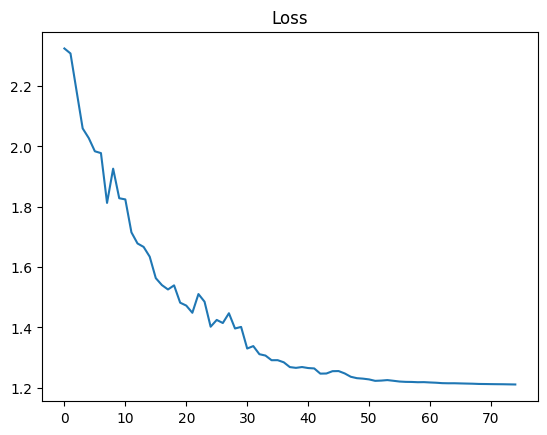

In [27]:
plt.title("Loss")
plt.plot(cl1_loss_res)

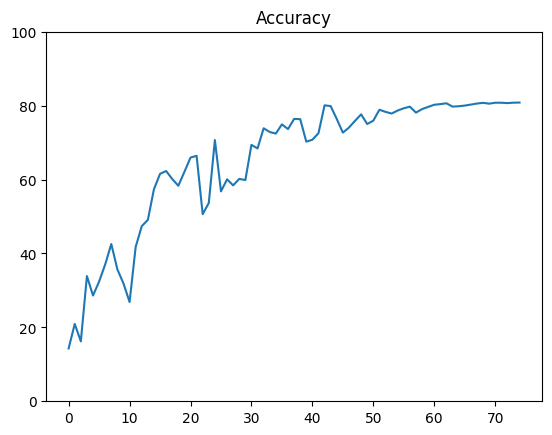

In [28]:
plt.title("Accuracy")
plt.ylim((0,100))
plt.plot(cl1_acc_res)